# **Final Python Notebook 2: Classification Modelling & Hyperparameters Tuning.**

In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

----------Load the Prepared Classification Dataset----------

In [32]:
classification_df = pd.read_csv('Classification Dataset.csv')

In [54]:
classification_df.head()

,Age,Sex,Occupation,T_Stage,N_Stage,6th_Stage,Differentiated,Grade,A_Stage,Tumor_Size,Estrogen_Status,Progesterone_Status,Regional_Node_Examined,Reginol_Node_Positive,Mortality_Status
0,68.0,Female,Teaching,T1,N1,IIA,Poorly differentiated,3,Regional,4.0,Positive,Positive,24.0,1,Alive
1,50.0,Female,Medical,T2,N2,IIIA,Moderately differentiated,2,Regional,35.0,Positive,Positive,14.0,5,Alive
2,58.0,Female,Engineering,T3,N3,IIIC,Moderately differentiated,2,Regional,63.0,Positive,Positive,14.0,7,Alive
3,58.0,Female,Technology,T1,N1,IIA,Poorly differentiated,3,Regional,18.0,Positive,Positive,2.0,1,Alive
4,47.0,Female,Multimedia,T2,N1,IIB,Poorly differentiated,3,Regional,41.0,Positive,Positive,3.0,1,Alive


In [33]:
# Splitting features and target
X = classification_df.drop('Mortality_Status', axis=1)
y = classification_df['Mortality_Status']

----------Encoding Categorical Features----------

In [34]:
# Create LabelEncoder object
le = LabelEncoder()

In [35]:
# Identify categorical columns (object type)
categorical_cols = X.select_dtypes(include=['object']).columns

In [36]:
# Apply label encoding to each categorical feature
for col in categorical_cols:
    X[col] = le.fit_transform(X[col])

In [37]:
# Also encode target column (y) if needed
if y.dtype == 'object':
    y = le.fit_transform(y)

----------Handling classes with very few samples----------

In [38]:
# Check class distribution
class_counts = pd.Series(y).value_counts()

In [39]:
# Only keep classes with at least 2 samples
valid_classes = class_counts[class_counts > 1].index

In [40]:
# Filter the data accordingly
mask = pd.Series(y).isin(valid_classes)
X = X[mask].reset_index(drop=True)
y = pd.Series(y)[mask].reset_index(drop=True)

----------Train-Test Split----------

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)

Training Features Shape: (2816, 14)
Testing Features Shape: (1207, 14)


----------Function to Plot ROC Curves for Multiclass----------

In [42]:
def plot_roc_curves(model, X_test, y_test, model_name):
    y_score = model.predict_proba(X_test)
    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(8, 6))
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multiclass ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

----------Model 1: Logistic Regression----------

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           2       0.86      0.98      0.92      1020
           3       0.00      0.00      0.00         3
           4       0.57      0.12      0.19       179
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         2

    accuracy                           0.85      1207
   macro avg       0.24      0.18      0.19      1207
weighted avg       0.81      0.85      0.80      1207

Logistic Regression ROC AUC Score: 0.7606957636577608


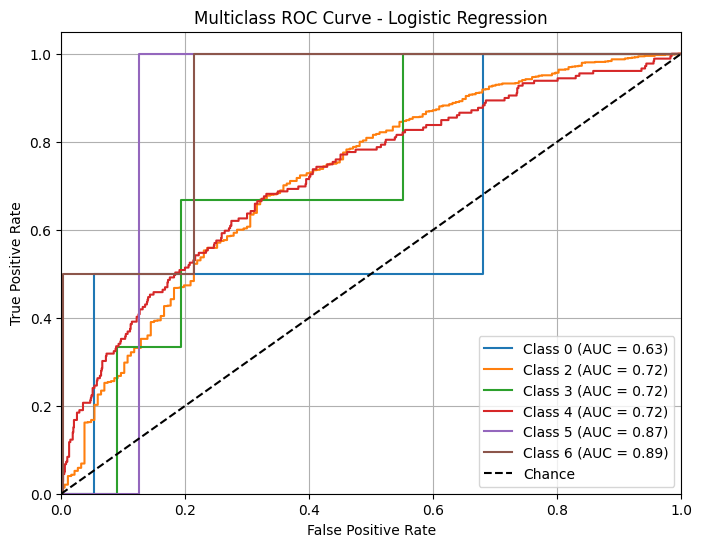

In [43]:
lr_model = LogisticRegression(max_iter=2000)
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

roc_auc_lr = roc_auc_score(y_test, lr_model.predict_proba(X_test), multi_class='ovr')
print("Logistic Regression ROC AUC Score:", roc_auc_lr)

# Plot ROC curve
plot_roc_curves(lr_model, X_test, y_test, "Logistic Regression")

----------Model 2: K-Nearest Neighbours (KNN)----------

K-Nearest Neighbours Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           2       0.85      0.97      0.91      1020
           3       0.00      0.00      0.00         3
           4       0.33      0.07      0.12       179
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         2

    accuracy                           0.83      1207
   macro avg       0.20      0.17      0.17      1207
weighted avg       0.77      0.83      0.79      1207

K-Nearest Neighbours ROC AUC Score: 0.5247264244193087


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


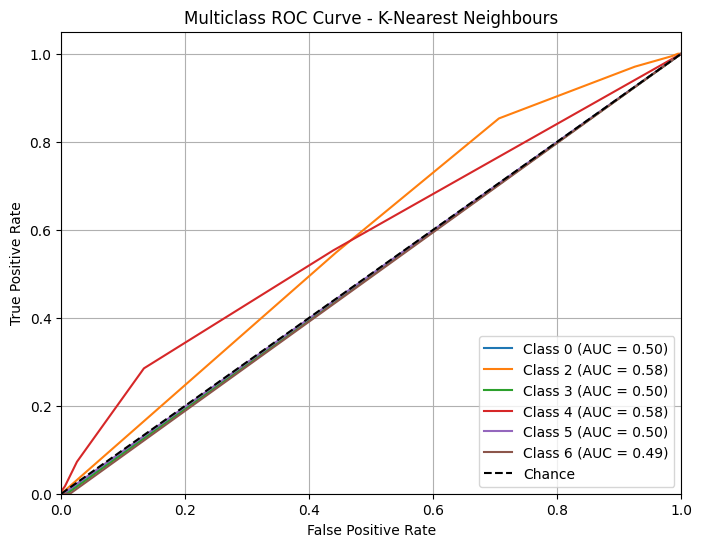

In [44]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)

print("K-Nearest Neighbours Classification Report:")
print(classification_report(y_test, y_pred_knn))

roc_auc_knn = roc_auc_score(y_test, knn_model.predict_proba(X_test), multi_class='ovr')
print("K-Nearest Neighbours ROC AUC Score:", roc_auc_knn)

# Plot ROC curve
plot_roc_curves(knn_model, X_test, y_test, "K-Nearest Neighbours")

----------Model 3: Naïve Bayes----------

Naïve Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.00      1.00      0.00         2
           2       0.94      0.02      0.03      1020
           3       0.01      0.33      0.02         3
           4       0.41      0.06      0.11       179
           5       0.00      0.00      0.00         1
           6       0.00      0.50      0.01         2

    accuracy                           0.03      1207
   macro avg       0.23      0.32      0.03      1207
weighted avg       0.86      0.03      0.04      1207

Naïve Bayes ROC AUC Score: 0.6558664492854912


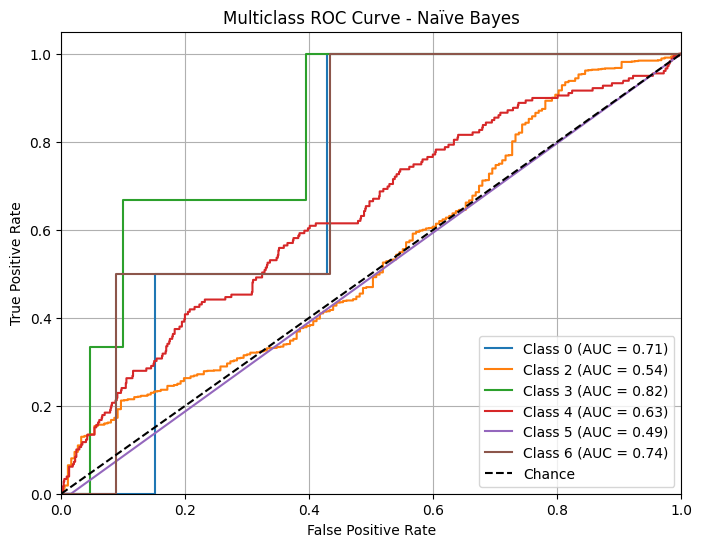

In [45]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

y_pred_nb = nb_model.predict(X_test)

print("Naïve Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))

roc_auc_nb = roc_auc_score(y_test, nb_model.predict_proba(X_test), multi_class='ovr')
print("Naïve Bayes ROC AUC Score:", roc_auc_nb)

# Plot ROC curve
plot_roc_curves(nb_model, X_test, y_test, "Naïve Bayes")

----------Hyperparameter Tuning: Logistic Regression----------

In [46]:
# Defining hyperparameter grid for Logistic Regression
param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

In [47]:
# Performing GridSearchCV
grid_search = GridSearchCV(LogisticRegression(max_iter=2000), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modu

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=2000),
             param_grid={'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']},
             scoring='accuracy')

In [48]:
# Displaying best hyperparameters
print("Best Hyperparameters for Logistic Regression:", grid_search.best_params_)

Best Hyperparameters for Logistic Regression: {'C': 0.1, 'solver': 'lbfgs'}


In [49]:
# Predicting with optimized model
best_lr_model = grid_search.best_estimator_
y_pred_best_lr = best_lr_model.predict(X_test)

In [50]:
# Evaluating the optimized Logistic Regression
print("Optimized Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_best_lr))

Optimized Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           2       0.86      0.99      0.92      1020
           3       0.00      0.00      0.00         3
           4       0.60      0.12      0.20       179
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         2

    accuracy                           0.85      1207
   macro avg       0.24      0.18      0.19      1207
weighted avg       0.81      0.85      0.80      1207



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [51]:
# ROC AUC Score for Optimized Logistic Regression
roc_auc_best_lr = roc_auc_score(y_test, best_lr_model.predict_proba(X_test), multi_class='ovr')
print("Optimized Logistic Regression ROC AUC Score:", roc_auc_best_lr)

Optimized Logistic Regression ROC AUC Score: 0.7743719447962558


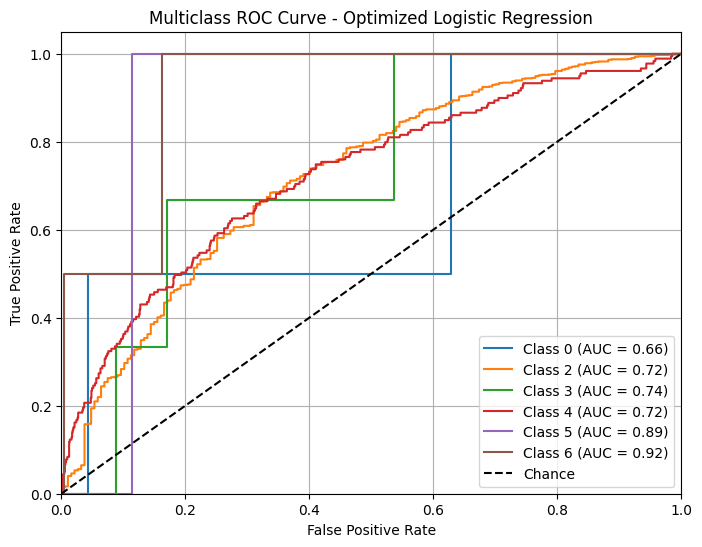

In [52]:
# Plot ROC curve
plot_roc_curves(best_lr_model, X_test, y_test, "Optimized Logistic Regression")